# Example: Solving the one dimensional Poisson equation

Here, the function $g(x)$ to solve for follows the equation 

$$ \label{ode}
-g''(x) = f(x),\qquad \qquad x \in (0,1)
$$

where $f(x)$ is a given function, along with the chosen conditions

$$ 
\begin{aligned} 
g(0) = g(1) = 0 
\end{aligned}\label{cond}
$$

In this example, we consider the case when $f(x) = (3x + x^2)\exp(x)$.

## Setting up the network

The deep neural network follows the same structure as in the previous examples.

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers
    N_hidden = np.size(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

The only changes to do compared to the previous examples, is to define a trial solution which satisfies the given conditions \eqref{cond} and express our current problem \eqref{ode} in the cost function. 

In [2]:
## Set up the cost function:

# The right side of the ODE
def f(x):
    return (3*x + x**2)*np.exp(x)

def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d2_g_t = elementwise_grad(elementwise_grad(g_trial_deep,0))(x,P)

    right_side = f(x)

    err_sqr = (-d2_g_t - right_side)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum

## The trial solution:
def g_trial_deep(x,P):
    return x*(1-x)*deep_neural_network(P,x)

The analytic solution for \eqref{ode} is

$$
g(x) = x(1 - x)\exp(x)
$$

In [3]:
def g_analytic(x):
    return x*(1-x)*np.exp(x)

## Solving the equation 

Now that the network is set up, along with the redefinitions describing our problem, we can try to solve the equation.

Initial cost: 1964.81
Final cost: 0.00204531
The max absolute difference between the solutions is: 0.000159952


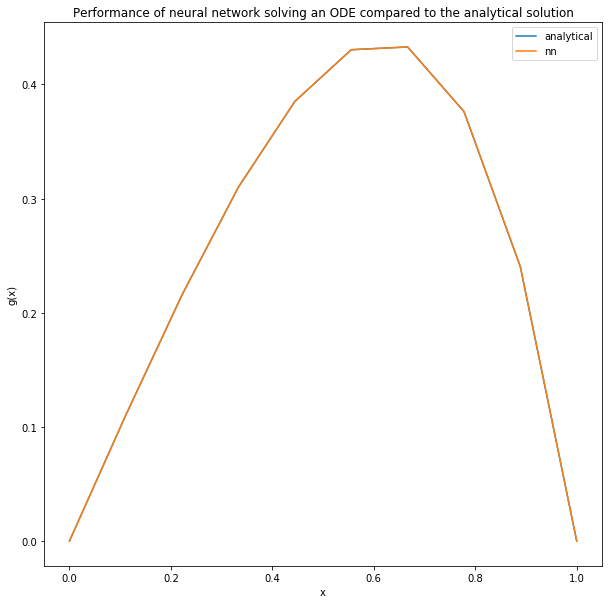

In [4]:
npr.seed(4155) 

## Decide the vales of arguments to the function to solve
Nx = 10
x = np.linspace(0,1, Nx)

## Set up the initial parameters
num_hidden_neurons = [20,10]
num_iter = 10000
lmb = 0.001

P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

g_dnn_ag = g_trial_deep(x,P)
g_analytical = g_analytic(x)

# Find the maximum absolute difference between the solutons:
max_diff = np.max(np.abs(g_dnn_ag - g_analytical))
print("The max absolute difference between the solutions is: %g"%max_diff)

plt.figure(figsize=(10,10))

plt.title('Performance of neural network solving an ODE compared to the analytical solution')
plt.plot(x, g_analytical)
plt.plot(x, g_dnn_ag[0,:])
plt.legend(['analytical','nn'])
plt.xlabel('x')
plt.ylabel('g(x)')
plt.show()

## Comparing with a numerical scheme

The equation \eqref{ode} is possible to solve using Taylor series to approximate the second derivative. 

Using Taylor series, the second derivative can be expressed as

$$
g''(x) = \frac{g(x + \Delta x) - 2g(x) + g(x-\Delta x)}{\Delta x^2} + E_{\Delta x}(x)
$$
where $\Delta x$ is a small step size and $E_{\Delta x}(x)$ being the error term. Looking away from the error terms gives an approximation to the second derivative

$$ \label{approx}
g''(x) \approx \frac{g(x + \Delta x) - 2g(x) + g(x-\Delta x)}{\Delta x^2}
$$

If $x_i = i \Delta x = x_{i-1} + \Delta x$ and $g_i = g(x_i)$ for $i = 1,\dots N_x - 2$ with $N_x$ being the number of values for $x$, \eqref{approx} becomes

$$
\begin{aligned}
g''(x_i) &\approx \frac{g(x_i + \Delta x) - 2g(x_i) + g(x_i -\Delta x)}{\Delta x^2} \\
&= \frac{g_{i+1} - 2g_i + g_{i-1}}{\Delta x^2}
\end{aligned}
$$

Since we know from \eqref{ode} that

$$
\begin{aligned}
-g''(x) &= f(x) \\
&= (3x + x^2)\exp(x)
\end{aligned}
$$

along with the conditions \eqref{cond} that $g(0) = g(1) = 0$, the following scheme can be used to find an approximate solution for $g(x)$ numerically:

$$ 
\begin{aligned}
-\Big( \frac{g_{i+1} - 2g_i + g_{i-1}}{\Delta x^2} \Big) &= f(x_i) \\
-g_{i+1} + 2g_i - g_{i-1} &= \Delta x^2 f(x_i)
\end{aligned}\label{odesys}
$$

for $i = 1, \dots, N_x - 2$ where $g_0 = g_{N_x - 1} = 0$ and $f(x_i) = (3x_i + x_i^2)\exp(x_i)$ from \eqref{ode}. 

Equation \eqref{odesys} can be rewritten into a matrix equation

$$
\begin{aligned}
\begin{pmatrix}
2 & -1 & 0 & \dots & 0 \\
-1 & 2 & -1 & \dots & 0 \\
\vdots & & \ddots & & \vdots \\
0 & \dots & -1 & 2 & -1  \\
0 & \dots & 0 & -1 & 2\\
\end{pmatrix}
\begin{pmatrix}
g_1 \\
g_2 \\
\vdots \\
g_{N_x - 3} \\
g_{N_x - 2}
\end{pmatrix}
&=
\Delta x^2
\begin{pmatrix}
f(x_1) \\
f(x_2) \\
\vdots \\
f(x_{N_x - 3}) \\
f(x_{N_x - 2})
\end{pmatrix} \\
A\vec{g} &= \vec{f}
\end{aligned}
$$
which makes it possible to solve for the vector $\vec{g}$.

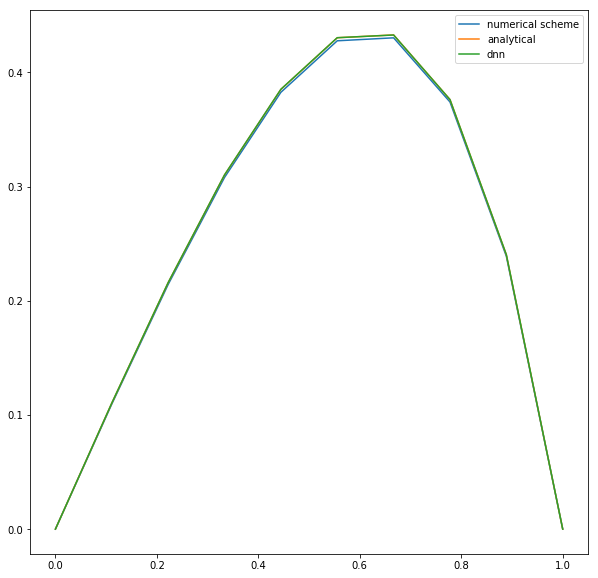

In [5]:
dx = 1/(Nx - 1)

# Set up the matrix A 
A = np.zeros((Nx-2,Nx-2))

A[0,0] = 2
A[0,1] = -1 

for i in range(1,Nx-3):
    A[i,i-1] = -1
    A[i,i] = 2
    A[i,i+1] = -1
    
A[Nx - 3, Nx - 4] = -1
A[Nx - 3, Nx - 3] = 2

# Set up the vector f 
f_vec = dx**2 * f(x[1:-1])

# Solve the equation
g_res = np.linalg.solve(A,f_vec)

g_vec = np.zeros(Nx)
g_vec[1:-1] = g_res

plt.figure(figsize=(10,10))

plt.plot(x,g_vec)
plt.plot(x,g_analytical)
plt.plot(x,g_dnn_ag[0,:])

plt.legend(['numerical scheme','analytical','dnn'])
plt.show()

As one can see from the plots, it appears that the neural network outperforms the numerical scheme based on Taylor series to approximate the second derivative in this case! To measure closer how close the solutions are to the analytical, the max value of the absolute differences between the solution is found below.  

In [6]:
diff1 = np.max(np.abs(g_vec - g_analytical))
diff_ag = np.max(np.abs(g_dnn_ag[0,:] - g_analytical))

print('The max absolute difference between the analytical solution and the solution found from the scheme: %g'%diff1)
print('The max absolute difference between the analytical solution and the solution found from the neural network: %g'%diff_ag)


The max absolute difference between the analytical solution and the solution found from the scheme: 0.00266858
The max absolute difference between the analytical solution and the solution found from the neural network: 0.000159952


## Using TensorFlow

The procedure is more or less similar as for the program used to solve the population model. What differs, is the definition of the cost function and the trial solutoin, defined in similar manner as in the implementation using Autograd.

Initial cost: 324.099
Final cost: 0.00461895

Max absolute difference between the analytical solution and solution from TensorFlow DNN: 0.000490608
Max absolute difference between the analytical solution and solution using Autograd DNN: 0.000159952


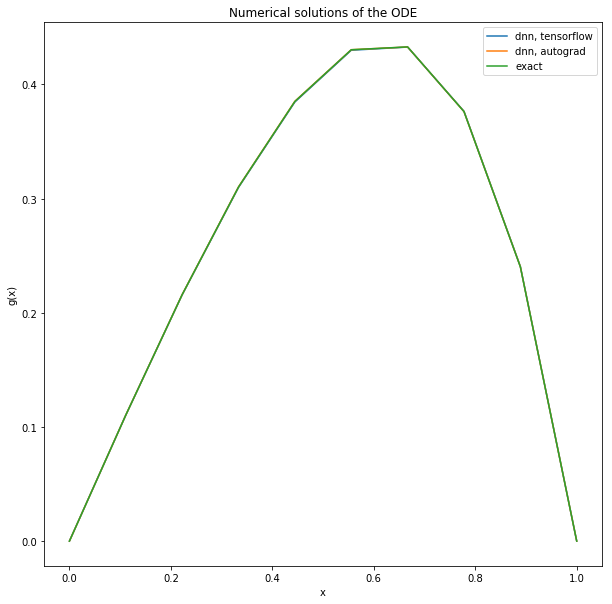

In [7]:
import tensorflow as tf

## Construction phase

# Just to reset the graph such that it is possible to rerun this
# Jupyter cell without resetting the whole kernel.
tf.reset_default_graph()

tf.set_random_seed(4155)

# Convert the values the trial solution is evaluated at to a tensor. 
x_tf = tf.convert_to_tensor(x.reshape(-1,1),dtype=tf.float64)


num_iter = 10000

# Define the number of neurons at each hidden layer
num_hidden_neurons = [20,10]
num_hidden_layers = np.size(num_hidden_neurons)

# Construct the network. 
# tf.name_scope is used to group each step in the construction,
# just for a more organized visualization in TensorBoard
with tf.name_scope('dnn'):
    
    # Input layer
    previous_layer = x_tf
    
    # Hidden layers
    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l], name='hidden%d'%(l+1), activation=tf.nn.sigmoid)
        previous_layer = current_layer
    
    # Output layer
    dnn_output = tf.layers.dense(previous_layer, 1, name='output')

# Define the cost function
with tf.name_scope('cost'):
    g_trial = x_tf*(1-x_tf)*dnn_output
    d_g_trial = tf.gradients(g_trial,x_tf)
    d2_g_trial = tf.gradients(d_g_trial,x_tf)
    
    right_side = (3*x_tf + x_tf**2)*tf.exp(x_tf)
    
    err = tf.square( -d2_g_trial[0] - right_side)
    cost = tf.reduce_sum(err, name = 'cost')

# Choose the method to minimize the cost function, along with a learning rate
learning_rate = 0.001
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
    traning_op = optimizer.minimize(cost)

g_dnn_tf = None

# Define a node that initializes all of the other nodes in the computational graph
# used by TensorFlow:
init = tf.global_variables_initializer()


## Execution phase

# Start a session where the graph defined from the construction phase can be evaluated at:

with tf.Session() as sess:
    # Initialize the whole graph
    init.run()
   
    # Evaluate the initial cost:
    print('Initial cost: %g'%cost.eval())
    
    # The traning of the network:
    for i in range(num_iter):
        sess.run(traning_op)
        
    # Training is done, and we have an approximate solution to the ODE
    print('Final cost: %g'%cost.eval())
    
    # Store the result
    g_dnn_tf = g_trial.eval()
    
    # Write the grapf such that it can be visualized in TensorBoard
    writer = tf.summary.FileWriter("./output", sess.graph)
    writer.close()

diff_tf = g_dnn_tf - g_analytical.reshape(-1,1)

print('\nMax absolute difference between the analytical solution and solution from TensorFlow DNN: %g'%np.max(np.abs(diff_tf)))
print('Max absolute difference between the analytical solution and solution using Autograd DNN: %g'%np.max(np.abs(diff_ag)))

# Plot the result
plt.figure(figsize=(10,10))

plt.title('Numerical solutions of the ODE')

plt.plot(x, g_dnn_tf)
plt.plot(x, g_dnn_ag[0,:])
plt.plot(x, g_analytical)

plt.legend(['dnn, tensorflow','dnn, autograd', 'exact'])
plt.xlabel('x')
plt.ylabel('g(x)')

plt.show()

## Using a different optimization algorithm implemented in TensorFlow

We can see that the results using Gradient Descent seems to converge towards the analytical solution. 
But there exists many other methods for optimization also, see [the TensorFlow documentation](https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers). 

Adam is an optimization algorithm that is adaptive and changes its learning paramaters accordingly to the function it tries to minimize. The algorithm is described in [this paper](https://arxiv.org/pdf/1412.6980.pdf). Here, we will only see the effect of choosing a different optimizer. 
Using the same TensorFlow program as before, the only change to do, is to replace the variable \textit{optimizer}.

Initial cost: 324.099
Final cost: 0.000345773

Max absolute difference between the analytical solution and solution from TensorFlow DNN: 7.11243e-05
Max absolute difference between the analytical solution and solution using Autograd DNN: 0.000159952


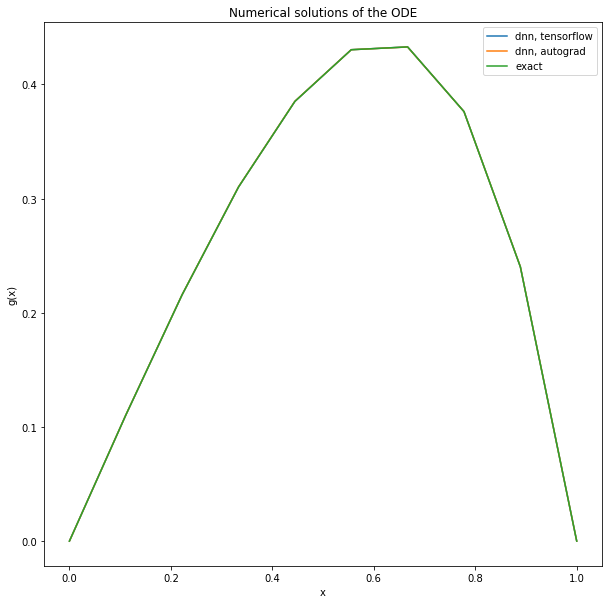

In [48]:
tf.reset_default_graph()
tf.set_random_seed(4155)

x_tf = tf.convert_to_tensor(x.reshape(-1,1),dtype=tf.float64)


num_iter = 10000

num_hidden_neurons = [20,10]
num_hidden_layers = np.size(num_hidden_neurons)

with tf.name_scope('dnn'):
    previous_layer = x_tf

    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l], name='hidden%d'%(l+1), activation=tf.nn.sigmoid)
        previous_layer = current_layer
    
    dnn_output = tf.layers.dense(previous_layer, 1, name='output')

with tf.name_scope('cost'):
    g_trial = x_tf*(1-x_tf)*dnn_output
    d_g_trial = tf.gradients(g_trial,x_tf)
    d2_g_trial = tf.gradients(d_g_trial,x_tf)
    
    right_side = (3*x_tf + x_tf**2)*tf.exp(x_tf)
    
    err = tf.square( -d2_g_trial[0] - right_side)
    cost = tf.reduce_sum(err, name = 'cost')

learning_rate = 0.001
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate) 
    traning_op = optimizer.minimize(cost)

g_dnn_tf = None

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()

    print('Initial cost: %g'%cost.eval())

    for i in range(num_iter):
        sess.run(traning_op)

    print('Final cost: %g'%cost.eval())

    g_dnn_tf = g_trial.eval()
    

diff_tf = g_dnn_tf - g_analytical.reshape(-1,1)

print('\nMax absolute difference between the analytical solution and solution from TensorFlow DNN: %g'%np.max(np.abs(diff_tf)))
print('Max absolute difference between the analytical solution and solution using Autograd DNN: %g'%np.max(np.abs(diff_ag)))

# Plot the result
plt.figure(figsize=(10,10))

plt.title('Numerical solutions of the ODE')

plt.plot(x, g_dnn_tf)
plt.plot(x, g_dnn_ag[0,:])
plt.plot(x, g_analytical)

plt.legend(['dnn, tensorflow','dnn, autograd', 'exact'])
plt.xlabel('x')
plt.ylabel('g(x)')

plt.show()